# Dependencies

In [1]:
! pip install geom
! pip install --upgrade -q wandb

In [2]:
import json 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import wandb

import torch
import torch.nn as nn
import torch.nn.functional as f
from torch import optim
from torch.utils.data import DataLoader, Dataset 
from torchvision import transforms

from sklearn.model_selection import train_test_split


import os
import sys
import warnings
warnings.filterwarnings('ignore')

# Config

In [3]:
class config:
    random_state = 424242
    DEBUG = False              # 1 for debugging
    
    if DEBUG:
        batch_size = 128
        epochs = 10
        img_ht, img_wd = 183, 256
        sample_size = 100
        
    else:
        batch_size = 128
        epochs = 100
        img_ht, img_wd = 183, 256
        
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device:{device}, Device count:{torch.cuda.device_count()}")

Device:cuda, Device count:2


In [4]:
# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# wandb_api_key = user_secrets.get_secret("wandb_api_key")
# wandb.login(key=wandb_api_key)

# Data Loading

In [5]:
img_dir1 = "/kaggle/input/visual-localization-aisingapore-train-images/train_images-1/train_images-1"
img_dir2 = "/kaggle/input/visual-localization-aisingapore-train-images/train_images-2/train_images-2"
img_dir3 = "/kaggle/input/visual-localization-aisingapore-train-images/train_images-3/train_images-3"
img_dir4 = "/kaggle/input/visual-localization-aisingapore-train-images/train_images-4/train_images-4"

# test_img_dir = "/kaggle/input/visual-localization-aisingapore-test-images/test_images"

params = "/kaggle/input/visual-localization-aisingapore-metadata/intrinsic_parameters.json"
sub_format = pd.read_csv("/kaggle/input/visual-localization-aisingapore-metadata/submission_format.csv")
train_labels = pd.read_csv("/kaggle/input/visual-localization-aisingapore-metadata/train_labels.csv")

In [6]:
imgset1 = os.listdir(img_dir1)
imgset2 = os.listdir(img_dir2)
imgset3 = os.listdir(img_dir3)
imgset4 = os.listdir(img_dir4)

# test_imgs = os.listdir(test_img_dir)
# around 10k images

In [7]:
with open(params) as json_file:
    data = json.load(json_file)
    print(data)

{'fx': 935.6461822571149, 'fy': 935.7779926708049, 'Cx': 1501.8278990534407, 'Cy': 1016.1713538034546, 'k1': 0, 'k2': 0, 'k3': 0, 'k4': 0, 'P1': 0, 'P2': 0}


In [8]:
train_labels.Timestamp = pd.to_datetime(train_labels.Timestamp)
train_labels.Timestamp

0       2018-05-02 02:51:12.897
1       2018-05-02 02:51:13.792
2       2018-05-02 02:51:14.667
3       2018-05-02 02:51:15.519
4       2018-05-02 02:51:16.352
                  ...          
10002   2018-12-28 01:12:28.271
10003   2018-12-28 01:12:28.625
10004   2018-12-28 01:12:28.980
10005   2018-12-28 01:12:29.334
10006   2018-12-28 01:12:29.689
Name: Timestamp, Length: 10007, dtype: datetime64[ns]

## Data Class

In [9]:
train_img_dir = "/kaggle/input/visual-localization-aisingapore-train-images"

In [10]:
train_img_dir = "/kaggle/input/visual-localization-aisingapore-train-images"
train_labels_path = "/kaggle/input/visual-localization-aisingapore-metadata/train_labels.csv"

label_names = ['Easting', 'Northing', 'Height', 'Roll', 'Pitch', 'Yaw']

In [11]:
class ImageDataset(Dataset):
    def __init__(self, labels_file=train_labels, img_dir=train_img_dir, transform=None):
        """
        train_labels : csv file obj of labels and ids of imgs
        img_dir : root img directory
        """
        self.img_labels = labels_file
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        traj = self.img_labels.loc[idx, "TrajectoryId"]
        filename = self.img_labels.loc[idx, 'Filename']
        img_path = self.img_dir + f"/train_images-{traj}/train_images-{traj}"
        img_path = os.path.join(img_path, filename)
                                
        image = read_image(img_path)
        labels = np.array(self.img_labels.loc[idx, label_names], dtype='float32')     # array of six
        
        if self.transform:
            image = self.transform(image)
            
        return image, labels
    
    
# 2048*256/2869 = 182.74241896131056  (img resizing)    
def read_image(path):
    """returns img read from path"""
    ht, wd = config.img_ht, config.img_wd
    img =  plt.imread(path)
    img = cv2.resize(img, (wd, ht))   # for cv2's resize (wd, ht) it is!
    img = img/255.0
    img = torch.FloatTensor(img.transpose((2, 0, 1)))  # Transpose the image to (C, H, W)
    return img

In [12]:
# Is random split a good idea??

if config.DEBUG:
    data = train_labels.sample(config.sample_size, random_state=config.random_state)
else:
    data = train_labels

train, val = train_test_split(data, test_size=0.2, random_state=config.random_state)

# reset train and val idxs
train.reset_index(inplace=True, drop=True)
val.reset_index(inplace=True, drop=True)

train.shape, val.shape

((8005, 9), (2002, 9))

In [13]:
training_data = ImageDataset(train)
val_data = ImageDataset(val)

# DataLoaders

train_loader = DataLoader(training_data, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=config.batch_size, shuffle=True)

In [14]:
for x, y in train_loader:
    print(len(x), len(y))
    break
    
x.shape, y.shape

128 128


(torch.Size([128, 3, 183, 256]), torch.Size([128, 6]))

# Modelling

**Dont forget to change the input for the fc1**

In [15]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.max_pooling = nn.MaxPool2d(3)
        self.avg_pooling = nn.AvgPool2d(3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=32832, out_features=1024)   ### CHANGE HERE..... 
        self.fc2 = nn.Linear(in_features=1024, out_features=256)
        self.output = nn.Linear(256, 6)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pooling(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pooling(x)
        
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.output(x)
        
        return x


In [16]:
model = SimpleNet()
print(model)

SimpleNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (max_pooling): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (avg_pooling): AvgPool2d(kernel_size=3, stride=3, padding=0)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=32832, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=6, bias=True)
)


In [17]:
import gc
gc.collect()

0

# Training

In [18]:
# # lame ass loss func!

# _EPS = torch.finfo(torch.float32).eps

# def degrees_to_radians(degrees):
#     return degrees * (torch.pi / 180.0)

# def euler_to_quaternion(roll: torch.Tensor, pitch: torch.Tensor, yaw: torch.Tensor) -> torch.Tensor:
#     roll = degrees_to_radians(roll)
#     pitch = degrees_to_radians(pitch)
#     yaw = degrees_to_radians(yaw)
#     cy = torch.cos(yaw * 0.5)
#     sy = torch.sin(yaw * 0.5)
#     cp = torch.cos(pitch * 0.5)
#     sp = torch.sin(pitch * 0.5)
#     cr = torch.cos(roll * 0.5)
#     sr = torch.sin(roll * 0.5)

#     w = cy * cp * cr + sy * sp * sr
#     x = cy * cp * sr - sy * sp * cr
#     y = sy * cp * sr + cy * sp * cr
#     z = sy * cp * cr - cy * sp * sr

#     return torch.stack([x, y, z, w], dim=1)


# def transformation_matrix(t: torch.Tensor, q: torch.Tensor, eps: float = _EPS) -> torch.Tensor:
#     arr_transforms = torch.eye(4).unsqueeze(0).repeat(t.shape[0], 1, 1)
#     arr_transforms[:, :3, 3] = t

#     nq = torch.square(torch.linalg.norm(q, dim=1))
#     mask = nq >= _EPS

#     q = torch.sqrt(2.0 / nq)[:, None] * q
#     q = q[:, :, None] * q[:, None, :]
#     arr_transforms[mask, 0, 0] = 1.0 - q[mask, 1, 1] - q[mask, 2, 2]
#     arr_transforms[mask, 0, 1] = q[mask, 0, 1] - q[mask, 2, 3]
#     arr_transforms[mask, 0, 2] = q[mask, 0, 2] + q[mask, 1, 3]
#     arr_transforms[mask, 1, 0] = q[mask, 0, 1] + q[mask, 2, 3]
#     arr_transforms[mask, 1, 1] = 1.0 - q[mask, 0, 0] - q[mask, 2, 2]
#     arr_transforms[mask, 1, 2] = q[mask, 1, 2] - q[mask, 0, 3]
#     arr_transforms[mask, 2, 0] = q[mask, 0, 2] - q[mask, 1, 3]
#     arr_transforms[mask, 2, 1] = q[mask, 1, 2] + q[mask, 0, 3]
#     arr_transforms[mask, 2, 2] = 1.0 - q[mask, 0, 0] - q[mask, 1, 1]
#     return arr_transforms


# def ominus(arr_a: torch.Tensor, arr_b: torch.Tensor) -> torch.Tensor:
#     return torch.matmul(torch.linalg.inv(arr_a), arr_b)


# def compute_distance(arr_transforms: torch.Tensor) -> torch.Tensor:
#     return torch.linalg.norm(arr_transforms[:, :3, 3], dim=1)


# # def compute_angle(arr_transforms: torch.Tensor) -> torch.Tensor:
# #     return torch.acos(torch.minimum(
# #         1,
# #         torch.maximum(
# #             -1,
# #             (torch.trace(arr_transforms[:, :3, :3], dim1=1, dim2=2) - 1) / 2,
# #         ),
# #     ))

# def compute_angle(arr_transforms: torch.Tensor) -> torch.Tensor:
#     trace_values = torch.diagonal(arr_transforms[:, :3, :3], dim1=-2, dim2=-1)
#     trace_values = torch.clamp(trace_values, -1, 3)
#     angle = torch.acos((trace_values - 1) / 2)
#     return angle


# def pose_loss(y_true, y_pred):
#     predicted_quats = euler_to_quaternion(roll=y_pred[:, 3], pitch=y_pred[:, 4], yaw=y_pred[:, 5])
#     actual_quats = euler_to_quaternion(roll=y_true[:, 3], pitch=y_true[:, 4], yaw=y_true[:, 5])

#     predicted_arr_transforms = transformation_matrix(y_pred[:, :3], predicted_quats)
#     actual_arr_transforms = transformation_matrix(y_true[:, :3], actual_quats)

#     i_predicted = predicted_arr_transforms[:-1, :, :]
#     j_predicted = predicted_arr_transforms[1:, :, :]
#     i_actual = actual_arr_transforms[:-1, :, :]
#     j_actual = actual_arr_transforms[1:, :, :]

#     error44 = torch.matmul(torch.inverse(i_predicted), j_predicted) - torch.matmul(torch.inverse(i_actual), j_actual)

#     rotation_errors = compute_angle(error44)
#     translation_errors = compute_distance(error44)

#     normalized_rotation_errors = rotation_errors / (2 * np.pi)
#     normalized_translation_errors = translation_errors / torch.max(translation_errors)

#     loss = torch.mean(normalized_rotation_errors) + torch.mean(normalized_translation_errors)

#     return loss

In [19]:
_EPS = torch.finfo(torch.float32).eps

def degrees_to_radians(degrees, device=device):
    return degrees * (torch.pi / 180.0)

def euler_to_quaternion(roll, pitch, yaw, device):
    roll = degrees_to_radians(roll, device)
    pitch = degrees_to_radians(pitch, device)
    yaw = degrees_to_radians(yaw, device)
    cy = torch.cos(yaw * 0.5)
    sy = torch.sin(yaw * 0.5)
    cp = torch.cos(pitch * 0.5)
    sp = torch.sin(pitch * 0.5)
    cr = torch.cos(roll * 0.5)
    sr = torch.sin(roll * 0.5)

    w = cy * cp * cr + sy * sp * sr
    x = cy * cp * sr - sy * sp * cr
    y = sy * cp * sr + cy * sp * cr
    z = sy * cp * cr - cy * sp * sr

    return torch.stack([x, y, z, w], dim=1).to(device)


def transformation_matrix(t, q, eps=_EPS, device=device):
    arr_transforms = torch.eye(4).unsqueeze(0).repeat(t.shape[0], 1, 1).to(device)
    arr_transforms[:, :3, 3] = t

    nq = torch.square(torch.linalg.norm(q, dim=1))
    mask = nq >= eps

    q = torch.sqrt(2.0 / nq)[:, None] * q
    q = q[:, :, None] * q[:, None, :]
    arr_transforms[mask, 0, 0] = 1.0 - q[mask, 1, 1] - q[mask, 2, 2]
    arr_transforms[mask, 0, 1] = q[mask, 0, 1] - q[mask, 2, 3]
    arr_transforms[mask, 0, 2] = q[mask, 0, 2] + q[mask, 1, 3]
    arr_transforms[mask, 1, 0] = q[mask, 0, 1] + q[mask, 2, 3]
    arr_transforms[mask, 1, 1] = 1.0 - q[mask, 0, 0] - q[mask, 2, 2]
    arr_transforms[mask, 1, 2] = q[mask, 1, 2] - q[mask, 0, 3]
    arr_transforms[mask, 2, 0] = q[mask, 0, 2] - q[mask, 1, 3]
    arr_transforms[mask, 2, 1] = q[mask, 1, 2] + q[mask, 0, 3]
    arr_transforms[mask, 2, 2] = 1.0 - q[mask, 0, 0] - q[mask, 1, 1]
    return arr_transforms


def ominus(arr_a, arr_b):
    return torch.matmul(torch.linalg.inv(arr_a), arr_b)


def compute_distance(arr_transforms):
    return torch.linalg.norm(arr_transforms[:, :3, 3], dim=1)


def compute_angle(arr_transforms):
    trace_values = torch.diagonal(arr_transforms[:, :3, :3], dim1=-2, dim2=-1)
    trace_values = torch.clamp(trace_values, -1, 3)
    angle = torch.acos((trace_values - 1) / 2)
    return angle


def pose_loss(y_true, y_pred, device=device):
    predicted_quats = euler_to_quaternion(y_pred[:, 3], y_pred[:, 4], y_pred[:, 5], device)
    actual_quats = euler_to_quaternion(y_true[:, 3], y_true[:, 4], y_true[:, 5], device)

    predicted_arr_transforms = transformation_matrix(y_pred[:, :3], predicted_quats, device=device)
    actual_arr_transforms = transformation_matrix(y_true[:, :3], actual_quats, device=device)

    i_predicted = predicted_arr_transforms[:-1, :, :]
    j_predicted = predicted_arr_transforms[1:, :, :]
    i_actual = actual_arr_transforms[:-1, :, :]
    j_actual = actual_arr_transforms[1:, :, :]

    error44 = torch.matmul(torch.inverse(i_predicted), j_predicted) - torch.matmul(torch.inverse(i_actual), j_actual)

    rotation_errors = compute_angle(error44)
    translation_errors = compute_distance(error44)

    normalized_rotation_errors = rotation_errors / (2 * np.pi)
    normalized_translation_errors = translation_errors / torch.max(translation_errors)

    loss = torch.mean(normalized_rotation_errors) + torch.mean(normalized_translation_errors)

    return loss

In [20]:
# Define the loss function
# criterion = nn.MSELoss()
criterion = pose_loss   # add weights!

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [21]:
# training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    model.to(device)
    running_loss = 0.0

    # Initialize the progress bar for training
    pbar_train = tqdm(total=len(train_loader), desc="Train", ncols=100)

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update the running loss
        running_loss += loss.item() * inputs.size(0)

        # Update the training progress bar
        pbar_train.update(1)
        pbar_train.set_postfix({"Loss": loss.item()})

    # Close the training progress bar
    pbar_train.close()

    # Calculate the average training loss
    train_loss = running_loss / len(train_loader.dataset)
    return train_loss

# validation function
def validate(model, val_loader, criterion, device):
    model.eval()
    model.to(device)
    val_loss = 0.0

    # Initialize the progress bar for validation
    pbar_val = tqdm(total=len(val_loader), desc="Validation", ncols=100)

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Calculate the loss
            loss = criterion(outputs, labels)

            # Update the validation loss
            val_loss += loss.item() * inputs.size(0)

            # Update the validation progress bar
            pbar_val.update(1)
            pbar_val.set_postfix({"Loss": loss.item()})

    # Close the validation progress bar
    pbar_val.close()

    # Calculate the average validation loss
    val_loss = val_loss / len(val_loader.dataset)
    return val_loss

# function for wandb tracking
def wandb_track(train_loss, val_loss):
    wandb.log({"train_loss": train_loss, "val_loss": val_loss})


# training loop function
def train_loop(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs):
    # Initialize lists to store losses for plotting
    train_losses = []
    val_losses = []

    # Initialize variables for early stopping
    best_val_loss = float('inf')
    patience_counter = 0

    # Initialize the overall progress bar
    pbar_epochs = tqdm(total=epochs, desc="Epochs", ncols=100, colour='green')

    for epoch in range(epochs):
        # Training step
        train_loss = train(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)

        # Validation step
        val_loss = validate(model, val_loader, criterion, device)
        val_losses.append(val_loss)

        # Print the training and validation loss for the epoch
        print(f"Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Save a checkpoint
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss
        }
        torch.save(checkpoint, 'checkpoint.pth')

        # Save the best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            torch.save(optimizer.state_dict(), 'best_optimizer.pth')

        # Update the learning rate scheduler
        scheduler.step(val_loss)

        ## Log losses to wandb
        # wandb_track(train_loss, val_loss)

        # Check for early stopping
        if epoch > cfg['patience'] and val_loss >= max(val_losses[-cfg['patience'] - 1:]):
            patience_counter += 1
            if patience_counter >= cfg['patience']:
                print("Early stopping!")
                break
        else:
            patience_counter = 0
        
        # Check if the minimum learning rate is reached
        current_lr = optimizer.param_groups[0]['lr']
        if current_lr <= 1e-07:
            print("Minimum learning rate reached! Halting Training!")
            break

        # Update the overall progress bar
        pbar_epochs.update(1)

    # Close the overall progress bar
    pbar_epochs.close()

    # Save the final model
    torch.save(model.state_dict(), 'final_model.pth')
    torch.save(optimizer.state_dict(), 'final_optimizer.pth')
    
    last_epoch = epoch
    return train_losses, val_losses, last_epoch

In [22]:
# # Initialize wandb
# wandb.init(project="Camera_pose_challenge", name="test_run_0")

# Define your configuration parameters
cfg = {
    'epochs': config.epochs,
    'lr': 0.001,
    'patience': 5,
    'factor': 0.1
}

# Define your model
model = SimpleNet()
# for 2 gpus!
model = nn.DataParallel(model)

# Define your loss function and optimizer
criterion = pose_loss
optimizer = optim.Adam(model.parameters(), lr=cfg['lr'])

# Define your learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=cfg['factor'], patience=cfg['patience'], verbose=True)

# Train the model
train_losses, val_losses, last_epoch = train_loop(model, train_loader, val_loader, criterion, optimizer, scheduler, device, cfg['epochs'])

# # Finish wandb run
# wandb.finish()

Train: 100%|████████████████████████████████████████████| 63/63 [09:15<00:00,  8.82s/it, Loss=0.794]

Validation: 100%|███████████████████████████████████████| 16/16 [01:58<00:00,  7.41s/it, Loss=0.788]


Epoch 1/100: Train Loss: 0.7512, Val Loss: 0.7771


Train: 100%|████████████████████████████████████████████| 63/63 [07:46<00:00,  7.40s/it, Loss=0.691]

Validation: 100%|███████████████████████████████████████| 16/16 [01:55<00:00,  7.24s/it, Loss=0.681]


Epoch 2/100: Train Loss: 0.7263, Val Loss: 0.7086


Train: 100%|████████████████████████████████████████████| 63/63 [07:33<00:00,  7.20s/it, Loss=0.593]

Validation: 100%|███████████████████████████████████████| 16/16 [01:49<00:00,  6.86s/it, Loss=0.621]


Epoch 3/100: Train Loss: 0.6722, Val Loss: 0.5862


Train: 100%|████████████████████████████████████████████| 63/63 [07:17<00:00,  6.95s/it, Loss=0.585]

Validation: 100%|███████████████████████████████████████| 16/16 [01:29<00:00,  5.61s/it, Loss=0.671]


Epoch 4/100: Train Loss: 0.5897, Val Loss: 0.5980


Train: 100%|████████████████████████████████████████████| 63/63 [07:00<00:00,  6.68s/it, Loss=0.607]

Validation: 100%|███████████████████████████████████████| 16/16 [01:43<00:00,  6.44s/it, Loss=0.673]


Epoch 5/100: Train Loss: 0.5847, Val Loss: 0.5861


Train: 100%|████████████████████████████████████████████| 63/63 [07:03<00:00,  6.72s/it, Loss=0.607]

Validation: 100%|███████████████████████████████████████| 16/16 [01:49<00:00,  6.85s/it, Loss=0.537]


Epoch 6/100: Train Loss: 0.5844, Val Loss: 0.5833


Train: 100%|████████████████████████████████████████████| 63/63 [07:02<00:00,  6.70s/it, Loss=0.596]

Validation: 100%|███████████████████████████████████████| 16/16 [01:39<00:00,  6.21s/it, Loss=0.607]


Epoch 7/100: Train Loss: 0.5812, Val Loss: 0.5820


Train: 100%|████████████████████████████████████████████| 63/63 [07:06<00:00,  6.77s/it, Loss=0.591]

Validation: 100%|███████████████████████████████████████| 16/16 [01:44<00:00,  6.54s/it, Loss=0.644]


Epoch 8/100: Train Loss: 0.5949, Val Loss: 0.5932


Train: 100%|████████████████████████████████████████████| 63/63 [07:03<00:00,  6.73s/it, Loss=0.518]

Validation: 100%|███████████████████████████████████████| 16/16 [01:49<00:00,  6.83s/it, Loss=0.574]


Epoch 9/100: Train Loss: 0.5843, Val Loss: 0.5847


Train: 100%|████████████████████████████████████████████| 63/63 [06:58<00:00,  6.64s/it, Loss=0.626]

Validation: 100%|███████████████████████████████████████| 16/16 [01:41<00:00,  6.37s/it, Loss=0.673]


Epoch 10/100: Train Loss: 0.5881, Val Loss: 0.5980


Train: 100%|████████████████████████████████████████████| 63/63 [07:15<00:00,  6.91s/it, Loss=0.665]

Validation: 100%|███████████████████████████████████████| 16/16 [01:43<00:00,  6.45s/it, Loss=0.529]


Epoch 11/100: Train Loss: 0.5982, Val Loss: 0.6041


Train: 100%|████████████████████████████████████████████| 63/63 [07:03<00:00,  6.72s/it, Loss=0.519]

Validation: 100%|███████████████████████████████████████| 16/16 [01:49<00:00,  6.86s/it, Loss=0.615]


Epoch 12/100: Train Loss: 0.6051, Val Loss: 0.5864


Train: 100%|████████████████████████████████████████████| 63/63 [07:06<00:00,  6.77s/it, Loss=0.538]

Validation: 100%|███████████████████████████████████████| 16/16 [01:42<00:00,  6.39s/it, Loss=0.657]


Epoch 13/100: Train Loss: 0.5953, Val Loss: 0.5962


Epochs:  13%|██████▏                                         | 13/100 [1:58:59<12:53:06, 533.18s/it]

Epoch 00013: reducing learning rate of group 0 to 1.0000e-04.



Train: 100%|████████████████████████████████████████████| 63/63 [07:04<00:00,  6.74s/it, Loss=0.598]

Validation: 100%|███████████████████████████████████████| 16/16 [01:44<00:00,  6.54s/it, Loss=0.694]


Epoch 14/100: Train Loss: 0.5930, Val Loss: 0.5992


Train: 100%|████████████████████████████████████████████| 63/63 [07:03<00:00,  6.72s/it, Loss=0.721]

Validation: 100%|███████████████████████████████████████| 16/16 [01:50<00:00,  6.89s/it, Loss=0.581]


Epoch 15/100: Train Loss: 0.5984, Val Loss: 0.5936


Train: 100%|█████████████████████████████████████████████| 63/63 [07:00<00:00,  6.67s/it, Loss=0.61]

Validation: 100%|███████████████████████████████████████| 16/16 [01:42<00:00,  6.38s/it, Loss=0.551]


Epoch 16/100: Train Loss: 0.5975, Val Loss: 0.5940


Train: 100%|█████████████████████████████████████████████| 63/63 [07:02<00:00,  6.70s/it, Loss=0.63]

Validation: 100%|███████████████████████████████████████| 16/16 [01:41<00:00,  6.33s/it, Loss=0.609]


Epoch 17/100: Train Loss: 0.5900, Val Loss: 0.6048


Train: 100%|████████████████████████████████████████████| 63/63 [06:57<00:00,  6.63s/it, Loss=0.663]

Validation: 100%|███████████████████████████████████████| 16/16 [01:46<00:00,  6.68s/it, Loss=0.607]


Epoch 18/100: Train Loss: 0.5921, Val Loss: 0.6141


Train: 100%|█████████████████████████████████████████████| 63/63 [06:48<00:00,  6.48s/it, Loss=0.59]

Validation: 100%|███████████████████████████████████████| 16/16 [01:42<00:00,  6.40s/it, Loss=0.659]


Epoch 19/100: Train Loss: 0.5964, Val Loss: 0.6187


Epochs:  19%|█████████                                       | 19/100 [2:51:32<11:46:26, 523.29s/it]

Epoch 00019: reducing learning rate of group 0 to 1.0000e-05.



Train: 100%|████████████████████████████████████████████| 63/63 [07:01<00:00,  6.69s/it, Loss=0.579]

Validation: 100%|███████████████████████████████████████| 16/16 [01:42<00:00,  6.39s/it, Loss=0.604]


Epoch 20/100: Train Loss: 0.5993, Val Loss: 0.6014


Train: 100%|████████████████████████████████████████████| 63/63 [06:59<00:00,  6.66s/it, Loss=0.653]

Validation: 100%|███████████████████████████████████████| 16/16 [01:48<00:00,  6.81s/it, Loss=0.687]


Epoch 21/100: Train Loss: 0.5979, Val Loss: 0.5870


Train: 100%|████████████████████████████████████████████| 63/63 [06:55<00:00,  6.60s/it, Loss=0.556]

Validation: 100%|███████████████████████████████████████| 16/16 [01:43<00:00,  6.46s/it, Loss=0.653]


Epoch 22/100: Train Loss: 0.5966, Val Loss: 0.5997


Train: 100%|████████████████████████████████████████████| 63/63 [06:47<00:00,  6.48s/it, Loss=0.535]

Validation: 100%|███████████████████████████████████████| 16/16 [01:39<00:00,  6.24s/it, Loss=0.558]


Epoch 23/100: Train Loss: 0.5981, Val Loss: 0.6052


Train: 100%|████████████████████████████████████████████| 63/63 [06:48<00:00,  6.49s/it, Loss=0.606]

Validation: 100%|███████████████████████████████████████| 16/16 [01:43<00:00,  6.44s/it, Loss=0.618]


Epoch 24/100: Train Loss: 0.5957, Val Loss: 0.5865


Train: 100%|████████████████████████████████████████████| 63/63 [06:52<00:00,  6.56s/it, Loss=0.701]

Validation: 100%|███████████████████████████████████████| 16/16 [01:43<00:00,  6.47s/it, Loss=0.644]


Epoch 25/100: Train Loss: 0.5919, Val Loss: 0.5850


Epochs:  25%|████████████                                    | 25/100 [3:43:28<10:47:08, 517.71s/it]

Epoch 00025: reducing learning rate of group 0 to 1.0000e-06.



Train: 100%|████████████████████████████████████████████| 63/63 [06:59<00:00,  6.66s/it, Loss=0.713]

Validation: 100%|███████████████████████████████████████| 16/16 [01:40<00:00,  6.30s/it, Loss=0.544]


Epoch 26/100: Train Loss: 0.5933, Val Loss: 0.6069


Train: 100%|████████████████████████████████████████████| 63/63 [06:53<00:00,  6.57s/it, Loss=0.698]

Validation: 100%|█████████████████████████████████████████| 16/16 [01:46<00:00,  6.63s/it, Loss=0.7]


Epoch 27/100: Train Loss: 0.6025, Val Loss: 0.6002


Train: 100%|█████████████████████████████████████████████| 63/63 [06:59<00:00,  6.65s/it, Loss=0.63]

Validation: 100%|███████████████████████████████████████| 16/16 [01:43<00:00,  6.50s/it, Loss=0.691]


Epoch 28/100: Train Loss: 0.5918, Val Loss: 0.5962


Train: 100%|████████████████████████████████████████████| 63/63 [06:56<00:00,  6.61s/it, Loss=0.648]

Validation: 100%|███████████████████████████████████████| 16/16 [01:39<00:00,  6.19s/it, Loss=0.601]


Epoch 29/100: Train Loss: 0.6011, Val Loss: 0.6025


Train: 100%|██████████████████████████████████████████████| 63/63 [06:55<00:00,  6.59s/it, Loss=0.6]

Validation: 100%|███████████████████████████████████████| 16/16 [01:45<00:00,  6.58s/it, Loss=0.658]


Epoch 30/100: Train Loss: 0.5935, Val Loss: 0.5932


Train: 100%|████████████████████████████████████████████| 63/63 [06:56<00:00,  6.61s/it, Loss=0.638]

Validation: 100%|███████████████████████████████████████| 16/16 [01:44<00:00,  6.52s/it, Loss=0.673]


Epoch 31/100: Train Loss: 0.5972, Val Loss: 0.6051


Epochs:  31%|███████████████▏                                 | 31/100 [4:35:36<9:59:05, 520.94s/it]

Epoch 00031: reducing learning rate of group 0 to 1.0000e-07.



Train: 100%|████████████████████████████████████████████| 63/63 [07:01<00:00,  6.69s/it, Loss=0.667]

Validation: 100%|███████████████████████████████████████| 16/16 [01:41<00:00,  6.36s/it, Loss=0.587]


Epoch 32/100: Train Loss: 0.6081, Val Loss: 0.6000


Train: 100%|████████████████████████████████████████████| 63/63 [07:01<00:00,  6.69s/it, Loss=0.608]

Validation: 100%|████████████████████████████████████████| 16/16 [01:46<00:00,  6.67s/it, Loss=0.64]


Epoch 33/100: Train Loss: 0.5947, Val Loss: 0.5963


Train: 100%|████████████████████████████████████████████| 63/63 [07:00<00:00,  6.67s/it, Loss=0.638]

Validation: 100%|███████████████████████████████████████| 16/16 [01:45<00:00,  6.59s/it, Loss=0.664]


Epoch 34/100: Train Loss: 0.6013, Val Loss: 0.6034


Train: 100%|████████████████████████████████████████████| 63/63 [07:04<00:00,  6.74s/it, Loss=0.608]

Validation: 100%|███████████████████████████████████████| 16/16 [01:42<00:00,  6.43s/it, Loss=0.607]


Epoch 35/100: Train Loss: 0.5976, Val Loss: 0.5913


Train: 100%|████████████████████████████████████████████| 63/63 [06:57<00:00,  6.63s/it, Loss=0.616]

Validation: 100%|███████████████████████████████████████| 16/16 [01:48<00:00,  6.77s/it, Loss=0.697]


Epoch 36/100: Train Loss: 0.5892, Val Loss: 0.6076


Train: 100%|████████████████████████████████████████████| 63/63 [07:00<00:00,  6.67s/it, Loss=0.601]

Validation: 100%|███████████████████████████████████████| 16/16 [01:47<00:00,  6.69s/it, Loss=0.633]


Epoch 37/100: Train Loss: 0.5925, Val Loss: 0.5971


Epochs:  36%|█████████████████▋                               | 36/100 [5:28:23<9:43:47, 547.31s/it]

Epoch 00037: reducing learning rate of group 0 to 1.0000e-08.
Minimum learning rate reached! Halting Training!


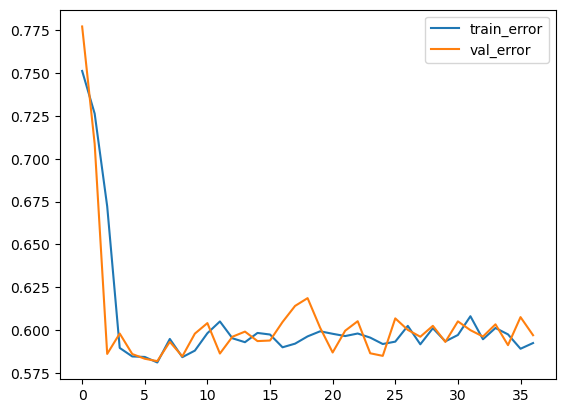

In [23]:
#  Plot loss
e = range(last_epoch+1)
plt.plot(e, train_losses, label='train_error')
plt.plot(e, val_losses, label='val_error')
plt.legend()

**ToDos**

- Try to have a simple pipeline for a small CNN. Memory efficient.
- What should be the ideal loss function? what did they use in midas or geonet or slam?
- Different pre-trained models to use.
- 